*Обучать надо в колабе на GPU*
### Домашнее задание №6

### Импорты

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

### Данные

In [3]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip
!unzip lenta_40k.csv.zip

--2025-02-07 17:36:21--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip [following]
--2025-02-07 17:36:22--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip’

lenta_40k.csv.zip   100%[===================>]  29.24M  --.-KB/s    in 0.1s    

2025-02-07 17

In [4]:
data = pd.read_csv('lenta_40k.csv.zip')
data.head()

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


### Препроцессинг (для обучения)

In [5]:
# "лингвистический" препроцессинг минимальный
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [6]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))
print(len(vocab))

354611


In [7]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)
print(len(filtered_vocab))

24091


In [8]:
# индексируем слова
word2id = {'PAD': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i: word for word, i in word2id.items()}
print([id2word[i] for i in range(5)])

['PAD', '', 'рафаэль', 'сорвался', 'пускать']


In [9]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)
print(MAX_LEN)

1748


In [10]:
# Можно посчитать среднюю или медианную длину,
# если максимальная кажется слишком большой

MEAN_LEN = np.median([len(x) for x in X])
print(MEAN_LEN)

QUARTILE_LEN = np.percentile(a=[len(x) for x in X], q=95)
print(QUARTILE_LEN)

MAX_LEN = int((MEAN_LEN + QUARTILE_LEN) / 2)
print(MAX_LEN)

170.0
304.0
237


In [11]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
print(X.shape)

(44356, 237)


In [12]:
# индексируем классы, которые надо угадывать
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}
print([id2label[i] for i in range(5)])

['Из жизни', 'Наука и техника', 'Библиотека', 'Бизнес', 'Культпросвет ']


In [13]:
# записываем классы в формат кераса
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])
print(len(label2id))

19


In [14]:
# Добавим стратификацию, т.к. в данных у нас дисбаланс классов
# Из документации: stratify: array-like object, by default it is None
# If None is selected, the data is stratified using these as class labels

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

### Обучение нейросети
### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.

**Справка из семинара**

...сверточным слоем. В керасе они называются Conv1D (2D тоже есть, они используются для картинок). Их нужно ставить сразу после Embedding слоя.

Сверточные слои можно накладывать друг на друга.

Давайте еще разберем параметры:
- **kernel_size** - это размер кусочков, к которым мы применяем сверточные матрицы (похоже на размер нграмма)
- **filters** - количество матриц свертки (это как бы размерность до которой будет сжат или развернут вектор)
- **stride** - шаг по которому выбираются кусочки из последовательности (это как параметр шаг в функции range в питоне)

Со сверточными слоями часто используется Pooling. Это тоже своего рода свертка, но без обучаемых параметров. В пулингах используется какое-то правило, по которому из чисел в каком-то окне выбирается 1 число (т.е. происходит свертка). В качестве правила используется максимум или среднее. Pooling слой ставят после сверточного.

Еще один параметр в сверточном слое - padding. Так как мы проходим каким-то окном по последовательности, на выходе последовательность сокращается. Но мы можем добавить нулей в начало и конец, чтобы на выходе было такое же число (padding='same').

Так мы можем наслаивать огромное количество слоев (она не уменьшается на каждом шаге).

Можно отдельно посмотреть, что делает паддинг в случае тензоров. Есть отдельный слой, который позволяет контролировать, куда и сколько паддить.

Теперь используем ZeroPadding1D чтобы добавить по два эмбеддинга с каждой стороны в каждый текст.

In [54]:
# определяем будущую архитектуру

inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(
    input_dim=len(word2id), output_dim=100)(inputs, )

# мы делаем несколько параллельных сверточных слоев (даже пар слоев с пулингом) с разным окном
# но из-за того, что мы сделали паддинг, длинна получается одинаковая и мы можем сконкатенировать
# векторы по второй размерности (так же как вы склеивали эбмединги от фастекста и ворд2века в предыдущей домашке)

convs = []
for ks in [2,3,4,5,6]:
    conv1 = keras.layers.Conv1D(
        kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    pool1 = keras.layers.AveragePooling1D(pool_size=3)(conv1)
    convs.append(pool1)
concat = keras.layers.concatenate(convs, axis=2)

drop = keras.layers.Dropout(0.25)(concat) # это значит что случайно заменяется половина всех значений

# а тут мы можем поставить еще свертку
conv_global = keras.layers.Conv1D(kernel_size=5, filters=24, strides=1)(drop)
pool2 = keras.layers.AveragePooling1D(pool_size=5)(conv_global)

# выход со сверточного слоя также можно просто конкатенировать
flatten = keras.layers.Flatten()(pool2)

dense = keras.layers.Dense(48, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

In [55]:
# создадим по архитектуре модель, создадим оптимизатор, скомпилируем
model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [56]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 237)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 237, 100)       │      2,409,200 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_76 (Conv1D)        │ (None, 237, 32)        │          6,432 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_77 (Conv1D)        │ (None, 237, 32)        │          9,632 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_78 (Conv1D)        │ (None, 237, 32)        │         12,832 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_79 (Conv1D)        │ (None, 237, 32)        │         16,032 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_80 (Conv1D)        │ (None, 237, 32)        │         19,232 │ embedding_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_42      │ (None, 79, 32)         │              0 │ conv1d_76[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_43      │ (None, 79, 32)         │              0 │ conv1d_77[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_44      │ (None, 79, 32)         │              0 │ conv1d_78[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_45      │ (None, 79, 32)         │              0 │ conv1d_79[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d_46      │ (None, 79, 32)         │              0 │ conv1d_80[0][0]        │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 79, 160)        │              0 │ average_pooling1d_42[… │
│ (Concatenate)             │                        │                │ average_pooling1d_43[… │
│                           │                        │                │ average_pooling1d_44[… │
│                           │                        │                │ average_pooling1d_45[… │
│                           │                        │                │ average_pooling1d_46[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 79, 160)        │              0 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_81 (Conv1D)   

 Total params: 2,510,843 (9.58 MB)

 Trainable params: 2,510,843 (9.58 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [58]:
# собственно обучение
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=3000,
          epochs=20,
          callbacks=[checkpoint, early_stop])

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.1977 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - loss: 0.1972 - rec@prec: 0.0000e+00 - val_loss: 0.1751 - val_rec@prec: 0.0000e+00
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.1716 - rec@prec: 2.3098e-05
Epoch 2: val_rec@prec improved from 0.00000 to 0.00180, saving model to model.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - loss: 0.1716 - rec@prec: 2.3138e-05 - val_loss: 0.1671 - val_rec@prec: 0.0018
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 0.1616 - rec@prec: 0.0013
Epoch 3: val_rec@prec improved from 0.00180 to 0.03652, saving model to model.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - loss: 0.1614 - rec@prec: 0.0014 - val_loss: 0.1474 - val_rec@prec: 0.0365
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.1367 - rec@prec: 0.1040
Epoch 4: val_rec@prec

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


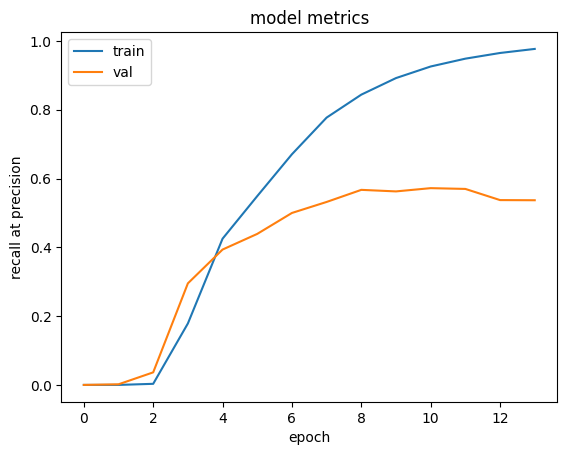

In [59]:
# визуализация обучения
print(model.history.history.keys())
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [ ]:
pass